In [1]:
# Import essential libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU, Input, UpSampling2D, Conv2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model


In [2]:
# Load and preprocess MNIST data
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
# Reshape the images to include a channel dimension and convert to float32
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# Normalize the pixel values to the range [-1, 1]
train_images = (train_images - 127.5) / 127.5  

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Create a TensorFlow dataset, shuffle and batch it
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [3]:
# Define the improved architecture of the generator model
def make_generator_model():
    inputs = Input(shape=(100,))  # Input layer for noise vector
    x = Dense(7*7*256, use_bias=False)(inputs)
    x = BatchNormalization()(x)  # Batch normalization
    x = LeakyReLU()(x)  # LeakyReLU activation
    x = Reshape((7, 7, 256))(x)
    x = UpSampling2D()(x)  # Upsample to 14x14
    x = Conv2D(128, kernel_size=5, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)  # Batch normalization
    x = LeakyReLU()(x)  # LeakyReLU activation
    x = UpSampling2D()(x)  # Upsample to 28x28
    x = Conv2D(64, kernel_size=5, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)  # Batch normalization
    x = LeakyReLU()(x)  # LeakyReLU activation
    outputs = Conv2D(1, kernel_size=5, strides=1, padding='same', activation='tanh')(x)  # Output layer with tanh activation

    model = Model(inputs=inputs, outputs=outputs)
    return model

generator = make_generator_model()


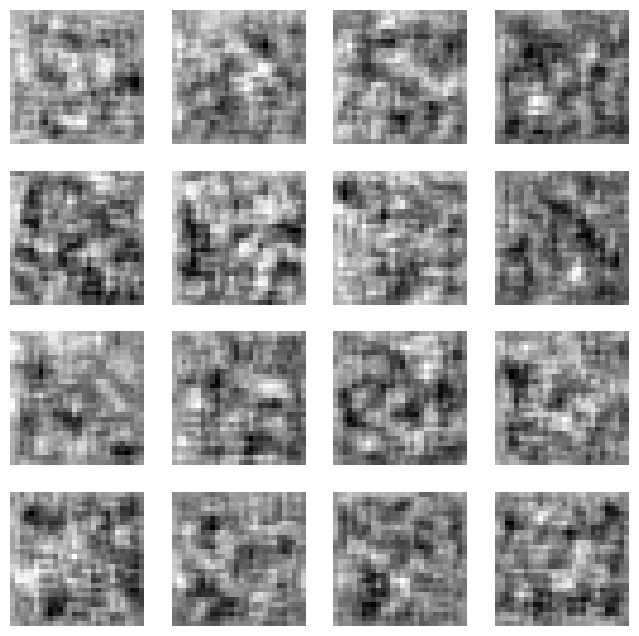

In [4]:
# Check generator outputs before training
noise = tf.random.normal([16, 100])  # Generate random noise
generated_images = generator(noise, training=False)

# Plot the generated images
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    axs[i // 4, i % 4].imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    axs[i // 4, i % 4].axis('off')
plt.show()

In [5]:
# Define the improved architecture of the discriminator model
def make_discriminator_model():
    inputs = Input(shape=(28, 28, 1))  # Input layer for 28x28 images
    x = Flatten()(inputs)  # Flatten the input
    x = Dense(64)(x)
    x = LeakyReLU()(x)  # LeakyReLU activation
    x = Dropout(0.3)(x)  # Add dropout layer
    x = Dense(128)(x)
    x = LeakyReLU()(x)  # LeakyReLU activation
    x = Dropout(0.3)(x)  # Add dropout layer
    outputs = Dense(1)(x)  # Output layer

    model = Model(inputs=inputs, outputs=outputs)
    return model

discriminator = make_discriminator_model()


In [6]:
# Define the loss functions and fine-tune learning rates for optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Loss for real images
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Loss for fake images
    total_loss = real_loss + fake_loss  # Total loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # Loss for generator

generator_optimizer = tf.keras.optimizers.Adam(1e-4)  # Optimizer for generator with learning rate
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)  # Optimizer for discriminator with learning rate


In [7]:
# Function to generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)  # Generate images from test input

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')  # Convert pixel values back to [0, 255]
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))  # Save the figure
    plt.show()


In [8]:
from IPython.display import clear_output

# Training parameters
EPOCHS = 100  # Increase the number of epochs for extended training
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])  # Fixed seed for generating consistent images

@tf.function
# Function for one training step
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)  # Generate images
        
        real_output = discriminator(images, training=True)  # Discriminator output for real images
        fake_output = discriminator(generated_images, training=True)  # Discriminator output for fake images
        
        gen_loss = generator_loss(fake_output)  # Generator loss
        disc_loss = discriminator_loss(real_output, fake_output)  # Discriminator loss
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)  # Gradients for generator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)  # Gradients for discriminator
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))  # Apply gradients for generator
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  # Apply gradients for discriminator

# Function to train the GAN
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        
        clear_output(wait=True)  # Clear output after each epoch
        generate_and_save_images(generator, epoch + 1, seed)  # Generate and save images after each epoch

    clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)  # Generate and save images after final epoch


In [ ]:
# Start extended training of the GAN
train(train_dataset, EPOCHS)
